In [ ]:
# Este cuaderno está basado en un cuaderno existente en la documentación de Unsloth "https://colab.research.google.com/github/timothelaborie/text_classification_scripts/blob/main/unsloth_classification.ipynb"

In [1]:
# Montar directorio de drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install unsloth

In [ ]:
from unsloth import tokenizer_utils  # Importo las utilidades relacionadas con el tokenizador del paquete Unsloth

# --- Sobrescribo la función 'fix_untrained_tokens' para que no haga nada ---
# Esto evita que Unsloth modifique automáticamente los tokens especiales (como <pad>, <unk>, etc.)
# cuando el modelo/tokenizador ya ha sido entrenado o preparado y no quiero que se altere.

def do_nothing(*args, **kwargs):
  pass  # Esta función vacía actúa como un "placeholder"

# Asigno la función vacía a 'fix_untrained_tokens' para desactivarla por completo
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
import torch
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
path = ''

In [ ]:
# --- Definición de nombres de columnas clave en el dataset ---
COLUMN_ID = 'id'                    # Identificador único de cada ejemplo
COLUMN_LETRA = 'lyrics'            # Columna que contiene la letra de la canción
COLUMN_ETIQUETA = 'label'          # Columna con la etiqueta binaria (0 = no misógina, 1 = misógina)
COLUMN_RAZONAMIENTO = 'reasoning'  # Razonamiento CoT generado por el modelo

# --- Ruta al archivo CSV con los datos de entrenamiento enriquecidos con razonamiento ---
csv_train_filepath = f'{path}/data/train_data/task1_GPT4o_dataReasoning.csv'

# --- Nombre del modelo base a usar desde Hugging Face vía Unsloth ---
model_name_unsloth = 'Qwen3-8B-Base-unsloth-bnb-4bit'  # Versión ligera en 4-bit, optimizada para fine-tuning rápido

In [ ]:
# Variables globales de configuración
NUM_CLASSES = 2
max_seq_length = 4096
dtype = None  # Automáticamente detectado (float16 o bfloat16 según GPU)
load_in_4bit = False

# Nombre del modelo de Unsloth
model_name = f"unsloth/{model_name_unsloth}"

In [ ]:
# Carga del modelo base con Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    load_in_4bit=load_in_4bit,
    max_seq_length=max_seq_length,
    dtype=dtype,
)

Major: 8, Minor: 9
==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/32.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
# --- Limitar las predicciones del modelo a solo los tokens numéricos usados como etiquetas ---

# 1. Obtener los token_ids correspondientes a las clases (0, 1, ..., NUM_CLASSES)
number_token_ids = []
for i in range(0, NUM_CLASSES + 1):
    token_id = tokenizer.encode(str(i), add_special_tokens=False)[0]
    number_token_ids.append(token_id)

# 2. Filtrar el peso original del lm_head para quedarnos solo con esos tokens
# lm_head: capa de salida del modelo (proyecta hacia el vocabulario completo)
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids, :])

# 3. Verificamos las dimensiones
old_shape = model.lm_head.weight.shape
print("Forma original del lm_head:", old_shape)
print("Forma filtrada (solo etiquetas numéricas):", par.shape)

# 4. Sustituimos la capa de salida por la versión filtrada
model.lm_head.weight = par

# 5. Crear un mapa inverso para luego poder traducir predicciones a clases originales
reverse_map = {value: idx for idx, value in enumerate(number_token_ids)}  # útil durante la inferencia
reverse_map

torch.Size([3, 4096])
torch.Size([151936, 4096])


{15: 0, 16: 1, 17: 2}

In [ ]:
# --- Configuración LoRA ---
lora_r = 16          # Rango bajo de las matrices LoRA (controla cuántos parámetros nuevos se introducen)
lora_alpha = 16      # Escala del adaptador LoRA (normalmente = r, pero puede ajustarse)

In [ ]:
# --- Configuración del Optimizador ---
learning_rate = 2e-5   # Tasa de aprendizaje para el entrenamiento

In [ ]:
# --- Selección del estilo de prompt ---
prompt_style = 0   # Define qué plantilla de prompt usar (puedes tener varias versiones para experimentar)

In [ ]:
# --- Aplicación de LoRA con unsloth ---
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_r,
    lora_alpha = lora_alpha,
    lora_dropout = 0,                    # Dropout desactivado para estabilidad
    bias = "none",
    target_modules = [
        "lm_head",                      # Ahora es pequeño (por reducción anterior), se puede adaptar
        "q_proj", "k_proj", "v_proj", "o_proj",           # Capas de atención
        "gate_proj", "up_proj", "down_proj"              # Capas del MLP
    ],
    use_gradient_checkpointing = "unsloth",
    use_rslora = True,                  # Activar Rank-Stabilized LoRA
    random_state = 3407,
)


Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.5.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 43659264


In [ ]:
# --- Verificar parámetros entrenables ---
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

In [ ]:
from datasets import Dataset
from sklearn.utils import resample
import pandas as pd
from sklearn.model_selection import train_test_split

# --- CARGA Y DIVISIÓN DE DATOS ---
print(f"Cargando datos desde: {csv_train_filepath}")
try:
    # 1. Cargar CSV con las letras y etiquetas
    df = pd.read_csv(csv_train_filepath, encoding='utf-8', encoding_errors="replace", sep=',')
    print(f"Columnas encontradas en el CSV: {df.columns.tolist()}")
    print(f"Total de filas válidas antes de dividir: {len(df)}")

    # 2. Dividir en Train, Validation y Test (estratificado)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[COLUMN_ETIQUETA])
    train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[COLUMN_ETIQUETA])

    print(f"División completada:")
    print(f"  - Tamaño del conjunto de Entrenamiento: {len(train_df)}")
    print(f"  - Tamaño del conjunto de Validación:    {len(valid_df)}")
    print(f"  - Tamaño del conjunto de Test:          {len(test_df)}")

    # --- VER DISTRIBUCIÓN DE CLASES ---
    print("\n--- Distribución de Clases ---")
    print("Conjunto de Entrenamiento:\n", train_df[COLUMN_ETIQUETA].value_counts())
    print("Conjunto de Validación:\n", valid_df[COLUMN_ETIQUETA].value_counts())
    print("Conjunto de Test:\n", test_df[COLUMN_ETIQUETA].value_counts())
    print("------------------------------------------")

    # --- BALANCEO POR OVERSAMPLING ---
    majority_class_df = train_df[train_df[COLUMN_ETIQUETA] == 0]
    minority_class_df = train_df[train_df[COLUMN_ETIQUETA] == 1]

    minority_oversampled_df = resample(
        minority_class_df,
        replace=True,       # Permitir duplicados
        n_samples=600,      # Fijar número para aproximar a un 60-40%
        random_state=42     # Reproducibilidad
    )

    train_df_balanced = pd.concat([majority_class_df, minority_oversampled_df])

    # --- OPCIÓN ALTERNATIVA: UNDERSAMPLING (comentada por defecto) ---
    # majority_undersampled_df = resample(majority_class_df, replace=False, n_samples=600, random_state=42)
    # train_df_balanced = pd.concat([majority_undersampled_df, minority_oversampled_df])

    # --- MEZCLAR EJEMPLOS Y MAPEAR LABELS ---
    train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    train_df_balanced['label'] = train_df_balanced['label'].replace({0: 1, 1: 2})
    valid_df['label'] = valid_df['label'].replace({0: 1, 1: 2})
    test_df['label'] = test_df['label'].replace({0: 1, 1: 2})

    # --- VERIFICACIÓN FINAL ---
    print("\nConjunto de Entrenamiento (balanceado):")
    print(train_df_balanced[COLUMN_ETIQUETA].value_counts())
    print("------------------------------------------")

except FileNotFoundError:
    print(f"Error: Archivo no encontrado en '{csv_train_filepath}'")
except Exception as e:
    print(f"Error inesperado durante la carga o división de datos: {e}")
    import traceback
    traceback.print_exc()

Cargando datos desde: /content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/data/train_data/task1_GPT4o_dataReasoning.csv
Columnas encontradas en el CSV: ['id', 'lyrics', 'reasoning', 'label']
Total de filas válidas antes de dividir: 2104
División completada:
  - Tamaño del conjunto de Entrenamiento: 1346
  - Tamaño del conjunto de Validación:  337
  - Tamaño del conjunto de Test:         421

--- Distribución de Clases ---
Conjunto de Entrenamiento:
label
0    935
1    411
Name: count, dtype: int64

Conjunto de Validación:
label
0    234
1    103
Name: count, dtype: int64

Conjunto de Test:
label
0    293
1    128
Name: count, dtype: int64
-----------------------------

Conjunto de Entrenamiento nuevo:
label
1    935
2    600
Name: count, dtype: int64
------------------------------------------


In [ ]:
from datasets import load_dataset
import datasets

# --- DEFINICIÓN DE PROMPTS ---
# Dos estilos distintos de prompt para elegir
prompt = [
    # Estilo 0: directo
    """Analiza la siguiente letra de canción:
{}

Clasificala esta canción en una de las siguientes categorías:
Clase 1: No Misógina
Clase 2: Misógina
SOLUCION
La cancion es: Clase {}""",

    # Estilo 1: con definición detallada
    """Analiza la siguiente letra de canción:
{}

Determina si el contenido transmite ideas, actitudes o expresiones que resulten ofensivas o denigrantes hacia las mujeres. Luego, clasifícala en una de estas dos clases:

Clase 1: No Misógina
La letra no incluye contenido sexista, violento, degradante ni estereotipos negativos hacia las mujeres.

Clase 2: Misógina
La letra presenta elementos como cosificación, insultos, violencia, dominio o estereotipos negativos hacia las mujeres.
SOLUCION:
La canción es: Clase {}"""
]

# --- FUNCIÓN PARA FORMATEAR LOS PROMPTS ---
def formatting_prompts_func(dataset_):
    texts = []
    for i in range(len(dataset_['lyrics'])):
        lyric = dataset_['lyrics'].iloc[i]
        label = dataset_['label'].iloc[i]
        prompt_text = prompt[prompt_style].format(lyric, label)
        texts.append(prompt_text)
    return texts

# --- APLICAR EL FORMATO A CADA CONJUNTO ---
train_df_balanced['text'] = formatting_prompts_func(train_df_balanced)
valid_df['text'] = formatting_prompts_func(valid_df)
test_df['text'] = formatting_prompts_func(test_df)

# --- CONVERTIR A DATASETS DE HUGGING FACE ---
train_dataset = datasets.Dataset.from_pandas(train_df_balanced, preserve_index=False)
eval_dataset = datasets.Dataset.from_pandas(valid_df, preserve_index=False)
test_dataset = datasets.Dataset.from_pandas(test_df, preserve_index=False)

In [12]:
train_dataset[3]

{'id': 'T1_TRAIN_0411',
 'lyrics': 'rdo mueve tu puerco ese ma-marrano come cacahuates pide pizza rin pero no invita a sus cuates en su escuela le apodaban el come quesadillas se come los melones sin quitarle las semillas ese marranete se atora en el retrete cada que lo veo es un apodo diferente se mira en el espejo, se pone consternado se quita la playera, es un tamal mal amarrado cerdo, no me llames cerdo mueve tu puerco cerdo, no me llames cerdo mueve tu puerco cerdo, no me llames cerdo mueve tu puerco cerdo, no me llames cerdo mueve tu puerco le le le piache las pastas, se mete tallarines debajo de su almohada encontrarás los tin-larines pasea en los pasillos de los supermercados comiendo bocadillos que le ofrecen los empleados antes de viajar, por cada cachete el chofer del autobús le cobra como flete le quita el migajón a todos los bolillos para después guardarlo y comerlo de sus bolsillos cerdo, no me llames cerdo mueve tu puerco cerdo, no me llames cerdo mueve tu puerco cerdo, 

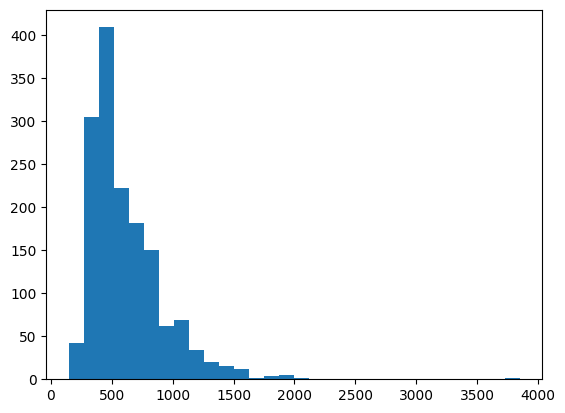

In [ ]:
import matplotlib.pyplot as plt

# --- Cálculo del número de tokens por texto ---
token_counts = [len(tokenizer.encode(x)) for x in train_df_balanced.text]

# --- Visualización ---
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(1024, color='red', linestyle='--', label='Máximo recomendado (1024)')
plt.xlabel('Número de tokens')
plt.ylabel('Número de ejemplos')
plt.title('Distribución de longitudes de tokens en el dataset de entrenamiento')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(f"Máximo número de tokens: {max(token_counts)}")
print(f"Ejemplos > 1024 tokens: {sum(t > 1024 for t in token_counts)} ({sum(t > 1024 for t in token_counts)/len(token_counts)*100:.2f}%)")

In [ ]:
# --- Data Collator personalizado ---
# Este collator modifica las etiquetas para que el modelo solo aprenda del último token de cada secuencia.
# Además, ajusta el índice del token final según el nuevo lm_head adaptado (post-filtrado).

class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,  # MLM desactivado (es importante en fine-tuning causal)
        ignore_index: int = -100,  # Valor usado para ignorar tokens en la pérdida
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        # Aplica la lógica base de DataCollatorForLanguageModeling
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Encuentra la posición del último token no ignorado (distinto de ignore_index)
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()

            # Ignora todos los tokens anteriores en la secuencia para que no contribuyan a la pérdida
            batch["labels"][i, :last_token_idx] = self.ignore_index

            # Reasigna el valor de la etiqueta del último token con el índice correcto del nuevo lm_head
            # Por ejemplo: si el token es '2', originalmente podía estar en posición 27 del vocabulario,
            # pero ahora '2' está en una nueva posición reducida según `number_token_ids` y `reverse_map`
            batch["labels"][i, last_token_idx] = reverse_map[ batch["labels"][i, last_token_idx].item() ]

        return batch

# Crear instancia del collator con el tokenizador
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

In [ ]:
from unsloth import is_bfloat16_supported
from transformers import EarlyStoppingCallback

trainer = SFTTrainer(
    model = model,                     # Modelo con LoRA ya aplicado
    tokenizer = tokenizer,            # Tokenizador cargado
    train_dataset = train_dataset,    # Conjunto de entrenamiento con formato adecuado
    eval_dataset = eval_dataset,      # Conjunto de validación
    max_seq_length = max_seq_length,  # Máximo número de tokens por entrada
    dataset_num_proc = 1,             # Número de procesos para map()
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],  # Early Stopping

    packing = False,                  # No se empaquetan múltiples ejemplos por entrada

    args = TrainingArguments(
        per_device_train_batch_size = 2,            # Batch size por GPU
        gradient_accumulation_steps = 32,           # Acumulación para batch efectivo más grande
        warmup_steps = 50,                          # Warmup inicial
        learning_rate = learning_rate,              # LR ajustado
        fp16 = not is_bfloat16_supported(),         # Usa FP16 si BF16 no está soportado
        bf16 = is_bfloat16_supported(),             # Usa BF16 si está disponible
        logging_steps = 25,                         # Logging frecuente
        optim = "adamw_8bit",                       # Optimizador eficiente
        weight_decay = 0.01,                        # Regularización
        lr_scheduler_type = "linear",               # LR scheduler lineal
        seed = 3407,                                # Reproducibilidad
        output_dir = f"{path}/cuadernos/outputs",   # Carpeta de salida

        num_train_epochs = 5,                       # Número de épocas

        eval_strategy = "steps",                    # Evaluación frecuente
        eval_steps = 25,
        save_strategy = "steps",                    # Guardado frecuente
        save_steps = 25,
        load_best_model_at_end = True,              # Carga el mejor modelo al final
        save_total_limit = 4,                       # Guarda los últimos 4
        metric_for_best_model = "eval_loss",        # Mejora basada en pérdida de validación
        report_to = "wandb",                        # Reportar a Weights & Biases
        group_by_length = True,                     # Agrupar por longitud similar (eficiencia)
    ),

    data_collator = collator,           # Collator personalizado para clasificación (último token)
    dataset_text_field = "text",        # Campo de entrada del dataset
)


Unsloth: Tokenizing ["text"]:   0%|          | 0/1535 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/337 [00:00<?, ? examples/s]

In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,535 | Num Epochs = 5 | Total steps = 120
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 32
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 32 x 1) = 64
 "-____-"     Trainable parameters = 43,659,264/7,612,077,056 (0.57% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: atorojaen (atorojaen-university-of-huelva) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
25,0.599700,0.455255
50,0.473100,0.407889
75,0.385700,0.392780
100,0.333100,0.403808


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
# --- Restaurar un lm_head completo después de haberlo reducido para el fine-tuning ---

# 1. Guardamos los pesos y bias entrenados del lm_head reducido (solo para los tokens 1 y 2)
trimmed_lm_head = model.lm_head.weight.data.clone()
trimmed_lm_head_bias = model.lm_head.bias.data.clone() if hasattr(model.lm_head, "bias") and model.lm_head.bias is not None else torch.zeros(len(number_token_ids), device=trimmed_lm_head.device)

# 2. Creamos un nuevo lm_head con el tamaño original del vocabulario (old_size), pero solo rellenamos las posiciones relevantes
hidden_dim = trimmed_lm_head.shape[1]
new_lm_head = torch.full((old_size, hidden_dim), 0, dtype=trimmed_lm_head.dtype, device=trimmed_lm_head.device)
new_lm_head_bias = torch.full((old_size,), -1000.0, dtype=trimmed_lm_head_bias.dtype, device=trimmed_lm_head_bias.device)

# 3. Copiamos los pesos entrenados en las posiciones originales correspondientes del vocabulario
for new_idx, orig_token_id in enumerate(number_token_ids):
    new_lm_head[orig_token_id] = trimmed_lm_head[new_idx]
    new_lm_head_bias[orig_token_id] = trimmed_lm_head_bias[new_idx]

# 4. Creamos un nuevo Linear layer que reemplaza al lm_head del modelo con la forma original
with torch.no_grad():
    new_lm_head_module = torch.nn.Linear(hidden_dim, old_size, bias=True, device=model.device)
    new_lm_head_module.weight.data.copy_(new_lm_head)
    new_lm_head_module.bias.data.copy_(new_lm_head_bias)

    # 5. Asignamos el nuevo módulo como "default" dentro de modules_to_save, como espera PEFT
    model.lm_head.modules_to_save["default"] = new_lm_head_module

# 6. Confirmamos que el proceso se ha realizado correctamente
print(f"Remade lm_head: shape = {model.lm_head.weight.shape}. Allowed tokens: {number_token_ids}")

Remade lm_head: shape = torch.Size([151936, 4096]). Allowed tokens: [15, 16, 17]


In [ ]:
final_save_path = f'{path}/models/Model-{model_name_unsloth}-SINCOT-R-{lora_r}-Alpha-{lora_alpha}-LR-{learning_rate}-Tarea-1-Prompt'

In [ ]:
print(f"\nGuardando el mejor modelo en: {final_save_path}")
trainer.save_model(final_save_path)
tokenizer.save_pretrained(final_save_path)


Guardando el mejor modelo en: /content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/models/Model-Meta-Llama-3.1-8B-bnb-4bit-SINCOT-R-16-Alpha-16-LR-2e-05-Tarea-1


('/content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/models/Model-Meta-Llama-3.1-8B-bnb-4bit-SINCOT-R-16-Alpha-16-LR-2e-05-Tarea-1/tokenizer_config.json',
 '/content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/models/Model-Meta-Llama-3.1-8B-bnb-4bit-SINCOT-R-16-Alpha-16-LR-2e-05-Tarea-1/special_tokens_map.json',
 '/content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/models/Model-Meta-Llama-3.1-8B-bnb-4bit-SINCOT-R-16-Alpha-16-LR-2e-05-Tarea-1/tokenizer.json')

In [ ]:
# --- Activar modo de inferencia rápida con Unsloth ---
FastLanguageModel.for_inference(model)  # Activa el modo de inferencia optimizada (hasta 2x más rápida)
print("Modo de inferencia activado correctamente.")

In [ ]:
from unsloth import FastLanguageModel

# --- Cargar modelo fine-tuneado desde la ruta guardada ---
model, tokenizer = FastLanguageModel.from_pretrained(
    final_save_path,
    load_in_4bit = False,        # Precisión completa
    max_seq_length = 4096,       # Máxima longitud para LongContext
    dtype = None,                # Auto-selección de tipo de precisión (fp16/bf16)
    use_exact_model_name = True  # Evita búsquedas en HuggingFace
)
print("Model loaded successfully.")

# --- Preparar para inferencia optimizada ---
FastLanguageModel.for_inference(model)

# Formatear el prompt correctamente
prompt = """Analiza la siguiente letra de canción:
{}

Clasificala esta canción en una de las siguientes categorías:
Clase 1: No Misógina
Clase 2: Misógina
SOLUCION
La cancion es: Clase {}"""

# --- Tokenizar entrada y pasarla al modelo ---
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# --- Generar la salida (predicción del modelo) ---
outputs = model.generate(
    **inputs,
    max_new_tokens=1,    # Solo necesitamos la clase predicha
    use_cache=True
)

# --- Decodificar y mostrar la salida ---
decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("\n--- Salida generada por el modelo ---")
print(decoded[0])


==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/32.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

Unsloth 2025.5.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


Model loaded successfully.
['Analiza la siguiente letra de canción:\n{}\n\nDetermina si el contenido transmite ideas, actitudes o expresiones que resulten ofensivas o denigrantes hacia las mujeres. Luego, clasifícala en una de estas dos clases:\n\nClase 1: No Misógina\nLa letra no incluye contenido sexista, violento, degradante ni estereotipos negativos hacia las mujeres.\n\nClase 2: Misógina\nLa letra presenta elementos como cosificación, insultos, violencia, dominio o estereotipos negativos hacia las mujeres.\nSOLUCION:\nLa canción es: Clase {}1']


In [9]:
max_seq_length = 4096
number_token_ids = [15, 16, 17]

Evaluating: 100%|██████████| 421/421 [01:40<00:00,  4.20it/s]



Validation accuracy: 73.16% (308/421)

--- Random samples ---

Text: s la vi por última vez aquella tarde cuando mi alegría poco a poco se alejaba y el pobre corazón, melancólico y cobarde al contemplar su rostro callaba senti frio, y era el frio de la ausencia senti m
True: 1  Pred: 1 ✅
Probs: 1: 0.500, 2: 0.500

Text: pasan las horas y sigo pensando ¿está bien o está mal? tocándome donde tocaste, a ver si se siente igual mi juicio falla cuando lo que quiero, va contra mi moral-al y siempre que quiero salir del vici
True: 1  Pred: 2 ❌
Probs: 1: 0.037, 2: 0.961

Text: n la letra completa no estara disponible pronto que me queria que me queria ja que no aguntaba la soledad que sin mi te morias que daba vueltas en la cama por que no me tenia y yo fui un tonto que cre
True: 1  Pred: 2 ❌
Probs: 1: 0.270, 2: 0.730

Text: salgo para la calle sin permiso desatada, tengo mi bebé y no le aviso en mi bolsillo un par de cigarrillos entrando en la disco, enseguida organizo la botella, pónganla en

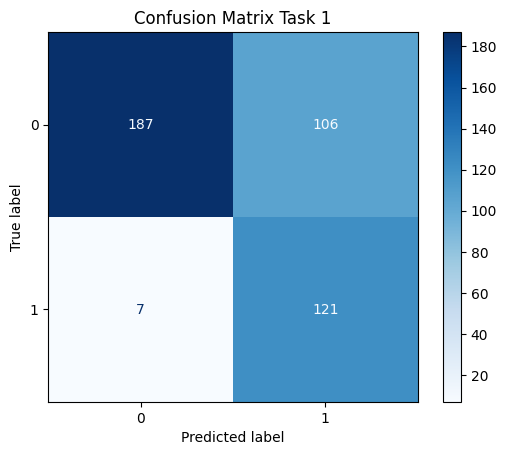

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Preparar plantilla del prompt para inferencia ---
inference_prompt_template = prompt.split("Clase {}")[0] + "Clase "

# --- Ordenar el conjunto de test por longitud para una inferencia más eficiente ---
test_df['token_length'] = test_df['lyrics'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
val_df_sorted = test_df.sort_values(by='token_length').reset_index(drop=True)

# --- Parámetros ---
display = 50                # Número de ejemplos aleatorios a mostrar
batch_size = 1              # Evaluación de uno en uno (puedes aumentar si tienes memoria)
device = model.device       # Dispositivo del modelo
correct = 0
results = []                # Para almacenar ejemplos individuales
all_preds = []
all_trues = []

# --- Inferencia ---
with torch.inference_mode():
    for i in tqdm(range(0, len(val_df_sorted), batch_size), desc="Evaluating"):
        batch = val_df_sorted.iloc[i:i+batch_size]
        
        # Crear prompts de entrada para cada ejemplo
        prompts = [inference_prompt_template.format(text) for text in batch['lyrics']]
        
        # Tokenizar los prompts
        inputs = tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_seq_length
        ).to(device)
        
        # Obtener logits del modelo
        logits = model(**inputs).logits
        
        # Extraer logits del último token no padding
        last_idxs = inputs.attention_mask.sum(1) - 1
        last_logits = logits[torch.arange(len(batch)), last_idxs, :]
        
        # Aplicar softmax y filtrar logits solo de los tokens de clase (number_token_ids)
        probs_all = F.softmax(last_logits, dim=-1)
        probs = probs_all[:, number_token_ids]
        
        # Predicción: argmax entre las clases válidas
        preds = torch.argmax(probs, dim=-1).cpu().numpy()

        # Comparar con etiquetas verdaderas
        true_labels = batch['label'].tolist()
        all_trues.extend(true_labels)
        all_preds.extend(preds)
        correct += sum([p == t for p, t in zip(preds, true_labels)])

        # Guardar ejemplos individuales para revisión
        for j in range(len(batch)):
            results.append({
                "text": batch['lyrics'].iloc[j][:200],
                "true": true_labels[j],
                "pred": preds[j],
                "probs": probs[j][1:].float().cpu().numpy(),  # Solo clases 1 y 2 (ignora clase 0 si no se usa)
                "ok": preds[j] == true_labels[j]
            })

# --- Métrica global de accuracy ---
accuracy = 100 * correct / len(val_df_sorted)
print(f"\nValidation accuracy: {accuracy:.2f}% ({correct}/{len(val_df_sorted)})")

# --- Muestra aleatoria de resultados ---
print("\n--- Random samples ---")
for s in random.sample(results, min(display, len(results))):
    print(f"\nText: {s['text']}")
    print(f"True: {s['true']}  Pred: {s['pred']} {'✅' if s['ok'] else '❌'}")
    print("Probs:", ", ".join([f"{k}: {v:.3f}" for k, v in enumerate(s['probs'], start=1)]))

# --- Matriz de confusión ---
cm = confusion_matrix(all_trues, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix Task 1")
plt.show()

# --- Limpieza: quitar columna auxiliar si existe ---
if 'token_length' in test_df:
    del test_df['token_length']